# 2021-10-21 Numerical integration for affordance based value calculation

Results below are for commit: ### (Rerunning the code below for other commits is not likely/guaranteed to give the same results.)

I have:
* Implemented a new function `sc_scenario_helper.get_access_order_values()` which does numerical integration to calculate the affordance-based values, so far only the kinematics-based terms in the integration. 
    * I am using a 0.1 s time step for the numerical integration. I tried 0.2 s, but the results looked quite inexact.
    * So far, the new/old vcalculations can be toggled with the `sc_scenario.NEW_AFF_VAL_CALCS` variable.
* Introduced a requirement in `SCAgent` that $T_p = \Delta t$, since that's how I do it anyway lately, and that simplifies the implementation of the numerical integration.
* Added some more testing code in `sc_scenario_helper` to test the `get_access_order_values()` function.
* Introduced the safety margins in a few more places in `sc_scenario_helper.get_access_order_implications()` - the new tests showed that weird situations could arise when an agent was already within the safety margin, which means that it can no longer pass in second (since it can't reverse, according to the current simplifying assumptions), but I still calculated a pass-second-acceleration, which both including reversing and was actually faulty in that it would induce a collision.

## Init

In [1]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))
print(sys.path[-1])

# imports needed to run the simulations
import numpy as np
import commotions
import sc_scenario
from sc_scenario import get_default_params, get_assumptions_dict, SCSimulation
from sc_scenario_helper import CtrlType

C:\GITHUB\COMMOTIONSFramework


## Unit tests, reproducing earlier results - unexpectedly closely!

I was expecting quite big changes in model behaviour with this modification, but actually no.

Just the base model, no interaction - not 100% identical, but very similar.

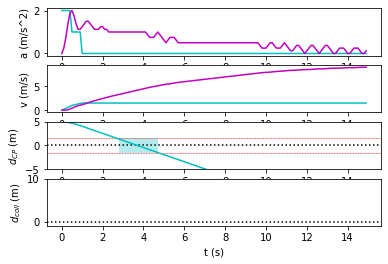

In [2]:
NAMES = ('P', 'V')
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = True, oBEo = False, oBEv = False, oAI = False, oEA = False)
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = NAMES)
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True)

Baseline kinematics, base model. Compare to the simulations in the 2021-10-19 diary notes. Again not 100% identical, but very close.

Initial car distance 30 m:


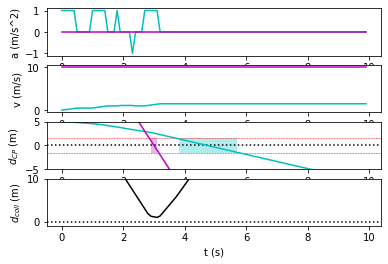

Initial car distance 40 m:


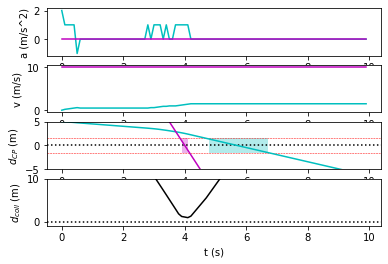

Initial car distance 50 m:


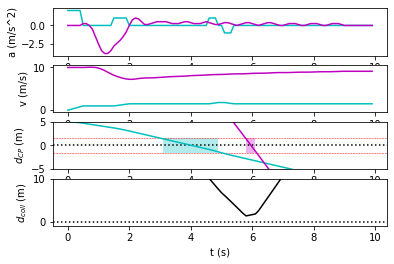

In [3]:
SPEEDS = np.array((0, 10))
PED_Y0 = -5
CONST_ACCS = (None, None)
AFF_VAL_FCN = True
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = False, oBEv = False, oAI = False, oEA = False)
(params, params_k) = sc_scenario.get_default_params(oVA = AFF_VAL_FCN)


def run_baseline_kinematics(dist0s = (30, 40, 50), plot_beh_probs = False, 
                            plot_beh_activs = False, plot_beh_accs = False,
                            plot_looming = False, ped_snaps = None, veh_snaps = None):
    for dist0 in dist0s:
        INITIAL_POSITIONS = np.array([[0, PED_Y0], [dist0, 0]])
        sc_simulation = SCSimulation(
                CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
                end_time = 10, optional_assumptions = optional_assumptions,
                agent_names = NAMES, const_accs = CONST_ACCS, params = params,
                snapshot_times = (ped_snaps, veh_snaps))
        sc_simulation.run()
        print('Initial car distance %d m:' % dist0)
        sc_simulation.do_plots(kinem_states = True, beh_probs = plot_beh_probs,
                              beh_activs = plot_beh_activs, beh_accs = plot_beh_accs,
                              looming = plot_looming)

run_baseline_kinematics()

And here is the same after restoring the pre-safety-margin settings. Compare to the 2021-10-13 notes or earlier - again surprisingly similar.

Initial car distance 30 m:


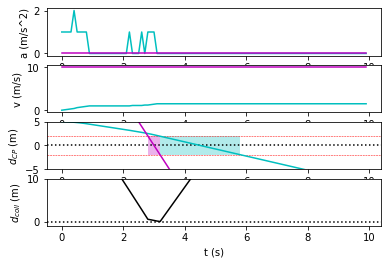

Initial car distance 40 m:


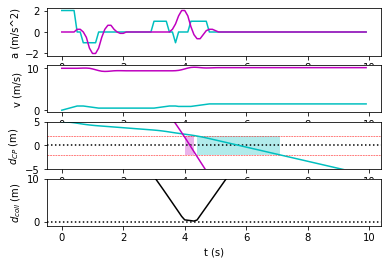

Initial car distance 50 m:


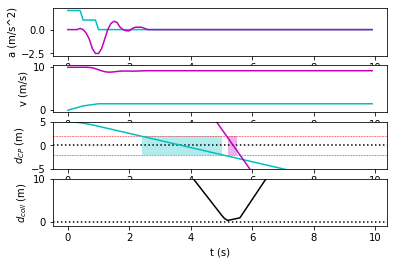

In [4]:
sc_scenario.SHARED_PARAMS.d_C = 2
params.T_s = 0
params.D_s = 0
run_baseline_kinematics()

## Conclusions

I have tried various other scenarios as well, and in general the behaviour is indeed very similar to what it was before. So introducing this numerical integration mostly seems like it slows down the simulations (by a factor of about two) without really adding benefits. So maybe the errors from the approximate value discounting weren't so big after all. It almost seems like it's the other way around - if I set a too large time step in the numerical integration, it is the numerical integration that becomes a poor approximation instead. 

Should try to run actual fits now though, before I say anything more - I want to check back on the simulation in the 2021-10-19 notes that made me want to do this to begin with. 

And then the real benefit could come when using the same basic numerical integration framework to also handle looming values better.